In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import math
import torch.optim as optim
import pickle

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
cuda = True if torch.cuda.is_available() else False
    
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor    

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [0]:
prefix_path = '/content/drive/My Drive/Data/'

In [0]:
def data_preprocessing(prefix_path):
  X_test = np.load(prefix_path+"X_test.npy")
  y_test = np.load(prefix_path+"y_test.npy")
  person_train_valid = np.load(prefix_path+"person_train_valid.npy")
  X_train_valid = np.load(prefix_path+"X_train_valid.npy")
  y_train_valid = np.load(prefix_path+"y_train_valid.npy")
  person_test = np.load(prefix_path+"person_test.npy")
  X_train_valid = X_train_valid[:,:22,:]
  X_test = X_test[:,:22,:]
  X_train_list=[]
  Y_train_list=[]
  X_test_list=[]
  Y_test_list=[]
  for i in range(9):
    idxs = np.argwhere(person_train_valid[:,0]==i).flatten()
    X_subject = X_train_valid[idxs]
    y_subject = y_train_valid[idxs]
    X_train_list.append(X_subject)
    Y_train_list.append(y_subject)
    idxs = np.argwhere(person_test[:,0]==i).flatten()
    X_subject_test = X_test[idxs]
    y_subject_test = y_test[idxs]
    X_test_list.append(X_subject_test)
    Y_test_list.append(y_subject_test)
  return X_train_valid, y_train_valid, X_test, y_test, X_train_list, Y_train_list,X_test_list,Y_test_list

In [0]:
X_train_valid, y_train_valid, X_test, y_test, X_train_list, Y_train_list,X_test_list,Y_test_list = data_preprocessing(prefix_path)

In [0]:
np.transpose(X_train_valid,(0,2,1)).shape

(2115, 1000, 22)

In [0]:
print('X_train_valid',np.shape(X_train_valid))
print('y_train_valid',np.shape(y_train_valid))
print('X_test',np.shape(X_test))
print('y_test',np.shape(y_test))
print('X_train_list',np.shape(X_train_list))
print('Y_train_list',np.shape( Y_train_list))
print('X_test_list',np.shape(X_test_list))
print('Y_test_list',np.shape(Y_test_list))



X_train_valid (2115, 22, 1000)
y_train_valid (2115,)
X_test (443, 22, 1000)
y_test (443,)
X_train_list (9,)
Y_train_list (9,)
X_test_list (9,)
Y_test_list (9,)


In [ ]:
def mov_d(data):
    res = []
    for i in range(np.shape(data)[0]):
        temp = []
        for n in range(np.shape(data)[1]):
            temp_t = m_avg(data[i][n],4,8)
            temp.append(temp_t)
        res.append(temp)
    return res
X_train_valid_avg_ = mov_d(X_train_valid)
X_test_valid_avg_ = mov_d(X_test)

In [0]:
with open (prefix_path+'train_after_.npy', 'rb') as fp:
  X_train_valid_avg = pickle.load(fp)
with open (prefix_path+'test_after_.npy', 'rb') as fp:
  X_test_valid_avg = pickle.load(fp)

In [0]:
np.shape(X_train_valid_avg)

(2115, 22, 248)

In [0]:
def train_valid_separate(X_train_valid, y_train_valid):
  dataset_size = X_train_valid.shape[0]
  indices = list(range(dataset_size))
  split = int(np.floor(0.2 * dataset_size))
  np.random.seed(42)
  np.random.shuffle(indices)
  train_indices, val_indices = indices[split:], indices[:split]
  train_data = X_train_valid[train_indices]
  train_label = y_train_valid[train_indices]
  valid_data = X_train_valid[val_indices]
  valid_label = y_train_valid[val_indices]
  return train_data, train_label, valid_data, valid_label

In [0]:
train_data, train_label, valid_data, valid_label = train_valid_separate(np.array(X_train_valid_avg), y_train_valid)


In [0]:
np.shape(train_data),np.shape(train_label)

((1692, 22, 248), (1692,))

In [0]:
def process_label(label):
  res = []
  for i in label:
    res.append(i%769)
  return res

In [0]:
train_data_o = np.transpose(train_data,(2,0,1))
train_label_o = process_label(train_label)
valid_data_o = np.transpose(valid_data,(2,0,1))
valid_label_o =  process_label(valid_label)

In [0]:
x_test_o = np.transpose( X_test,(2,0,1))
y_test_o = process_label(y_test)

In [0]:
features = 22
seq_len = np.shape(train_data)[2]
hidden_size = 100
batch_size = 18
out_size = 4
num_l = 1
last_cell =200
class GRU_model(nn.Module):
    def __init__(self,features,hidden_size,out_size):
        super(GRU_model, self).__init__()
        self.rnn = nn.GRU(input_size=features,
                            hidden_size=hidden_size,
                            num_layers=num_l,dropout = 0.2,
                         bidirectional = True )
        self.dense = nn.Linear(2*hidden_size, out_size)
        self.dropout = nn.Dropout(p = 0.5)
        self.softmax = nn.Softmax()
        
    def forward(self, x, hidden,seq_len,hidden_size):
        x, hidden = self.rnn(x, hidden)
        x = self.dropout(x)
        x =x[-last_cell:]
        x = self.dense(x)
     
        return x

    def init_hidden(self,features,batch_size,hidden_size):
        weight = next(self.parameters()).data
        return Variable(weight.new(2*num_l, batch_size, hidden_size).zero_())
      
      
def train():
  
  for epoch in range(len(train_data_o) // batch_size):
    X_batch = Variable(torch.FloatTensor(train_data_o[:, epoch*batch_size: (epoch+1)*batch_size, :]).cuda())
    y_batch = Variable(torch.LongTensor(np.tile(train_label_o[epoch*batch_size: (epoch+1)*batch_size],last_cell)).cuda())
    model.zero_grad()
    hidden = model.init_hidden(features,batch_size,hidden_size)
    output = model.forward(X_batch, hidden,seq_len,hidden_size)
    output = output.view(-1,out_size)
    loss = criterion(output, y_batch)
    loss.backward()
    optimizer.step()
  return loss

epoch = 650
model = GRU_model(features,hidden_size,out_size).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)
res_training_acc = []
res_val_acc = []
for e in range(epoch):

    
  print('epoch: ',e)
  if e%10==1:
    hidden = model.init_hidden(features,1692,hidden_size)
    output = model.forward(Variable(torch.FloatTensor(train_data_o).cuda()), hidden,seq_len,hidden_size)
    xx = output.cpu().detach().numpy()
    temp = np.argmax(np.mean(xx,axis = 0),axis=1)
    res_training_acc.append(np.sum(temp==train_label_o)/len(temp))
    
    hidden = model.init_hidden(features,len(valid_data),hidden_size)
    output = model.forward(Variable(torch.FloatTensor(valid_data_o).cuda()), hidden,seq_len,hidden_size)
    xx = output.cpu().detach().numpy()


    temp = np.argmax(np.mean(xx,axis = 0),axis=1)

    res_val_acc.append(np.sum(temp==valid_label_o)/len(temp))

  loss = train()
  print(loss.item())


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:46: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


epoch:  0
1.50314199924469
epoch:  1
1.4815384149551392
epoch:  2
1.4766134023666382
epoch:  3
1.4697072505950928
epoch:  4
1.4488050937652588
epoch:  5
1.4530444145202637
epoch:  6
1.441017746925354
epoch:  7
1.437720537185669
epoch:  8
1.4408745765686035
epoch:  9
1.4268900156021118
epoch:  10
1.4347586631774902
epoch:  11
1.4337818622589111
epoch:  12
1.4333463907241821
epoch:  13
1.426049828529358
epoch:  14
1.4229642152786255
epoch:  15
1.4314355850219727
epoch:  16
1.4111272096633911
epoch:  17
1.4212331771850586
epoch:  18
1.4198923110961914
epoch:  19
1.4236019849777222
epoch:  20
1.4232046604156494
epoch:  21
1.4183499813079834
epoch:  22
1.4110276699066162
epoch:  23
1.4099397659301758
epoch:  24
1.4099082946777344
epoch:  25
1.412623405456543
epoch:  26
1.4052408933639526
epoch:  27
1.4079731702804565
epoch:  28
1.4138277769088745
epoch:  29
1.4062834978103638
epoch:  30
1.4016282558441162
epoch:  31
1.4020477533340454
epoch:  32
1.4039127826690674
epoch:  33
1.4016594886779

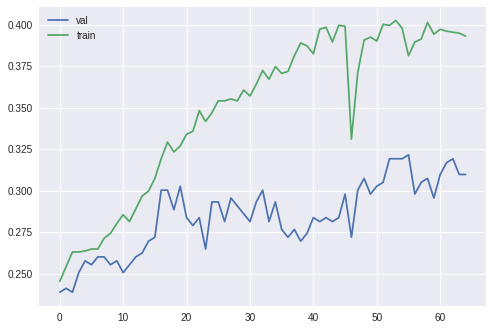

In [0]:
import matplotlib.pyplot as plt
plt.plot(res_val_acc)
plt.plot(res_training_acc)
plt.gca().legend(('val','train'))